In [9]:
!pip install --upgrade pip
!pip install pandas numpy scikit-learn xgboost lightgbm catboost optuna matplotlib seaborn

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 41.8 MB/s eta 0:00:00


In [10]:
!pip install optuna-integration[xgboost]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

# Hyperparameter Optimization
import optuna
from optuna.integration import XGBoostPruningCallback

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization styles
sns.set(style="whitegrid")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [11]:
# Load the data
train_url = "https://github.com/casbdai/notebooks/raw/main/Module3/99_CAS_BDAI_CUP/train.csv"
test_url = "https://github.com/casbdai/notebooks/raw/main/Module3/99_CAS_BDAI_CUP/test.csv"

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# Display the first few rows to verify
print("Training Data Head:")
print(train.head())

print("\nTest Data Head:")
print(test.head())

Training Data Head:
       model  year  price transmission  mileage fuelType  tax   mpg  \
0     Tiguan  2020  29999    Automatic     2728   Diesel  145  47.9   
1         Up  2018   8750       Manual    12500   Petrol  145  64.2   
2   2 Series  2019  22646       Manual      123   Petrol  145  52.3   
3   1 Series  2019  21950       Manual     5013   Petrol  145  44.1   
4         X3  2013  13100    Automatic    64455   Diesel  160  50.4   

   engineSize brand     ID  
0         2.0    VW  40452  
1         1.0    VW  33997  
2         1.5   BMW  24566  
3         1.5   BMW  30438  
4         2.0   BMW  22552  

Test Data Head:
        model  year transmission  mileage fuelType  tax   mpg  engineSize  \
0        Golf  2015       Manual    40000   Petrol  205  39.8         2.0   
1   GLA Class  2017    Automatic    30112   Petrol  145  43.5         2.0   
2    1 Series  2015    Semi-Auto    19168   Petrol  145  49.6         1.6   
3     B Class  2019    Semi-Auto    14700   Petrol  14

In [12]:
# Display basic statistics
print("\nBasic Statistical Details:")
print(train.describe())


Basic Statistical Details:
               year          price        mileage           tax           mpg  \
count  30857.000000   30857.000000   30857.000000  30857.000000  30857.000000   
mean    2017.231844   20758.643452   23300.447030    120.812295     54.436770   
std        2.087807    9786.994817   22313.826135     60.572940     14.863921   
min     1996.000000     650.000000       1.000000      0.000000      0.300000   
25%     2016.000000   13990.000000    5931.000000    125.000000     45.600000   
50%     2017.000000   19250.000000   17000.000000    145.000000     53.300000   
75%     2019.000000   25491.000000   33814.000000    145.000000     61.400000   
max     2020.000000  149948.000000  214000.000000    580.000000    217.300000   

         engineSize            ID  
count  30857.000000  30857.000000  
mean       1.873821  23377.013255  
std        0.539387  13450.630512  
min        0.000000      0.000000  
25%        1.500000  11766.000000  
50%        2.000000  23444

In [13]:
# Check data types and missing values
print("\nData Types and Missing Values:")
print(train.info())


Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30857 entries, 0 to 30856
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         30857 non-null  object 
 1   year          30857 non-null  int64  
 2   price         30857 non-null  int64  
 3   transmission  30857 non-null  object 
 4   mileage       30857 non-null  int64  
 5   fuelType      30857 non-null  object 
 6   tax           30857 non-null  int64  
 7   mpg           30857 non-null  float64
 8   engineSize    30857 non-null  float64
 9   brand         30857 non-null  object 
 10  ID            30857 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 2.6+ MB
None


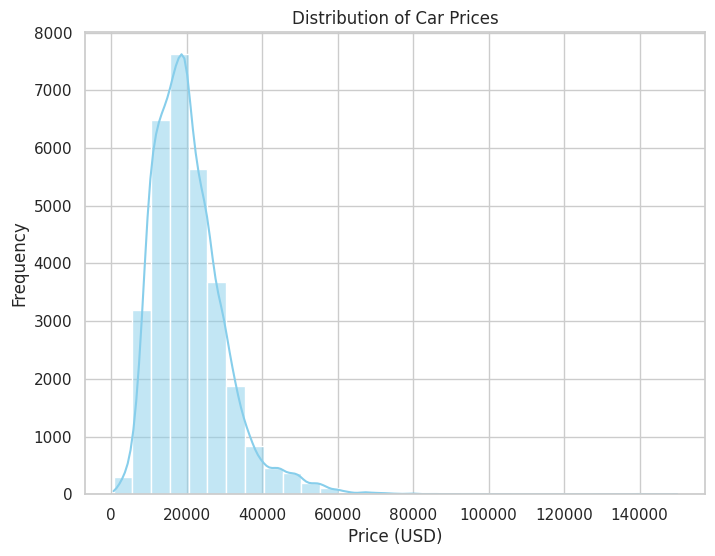

In [14]:
# Plot distribution of Price
plt.figure(figsize=(8,6))
sns.histplot(train['price'], kde=True, bins=30, color='skyblue') # Changed 'Price' to 'price'
plt.title('Distribution of Car Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()

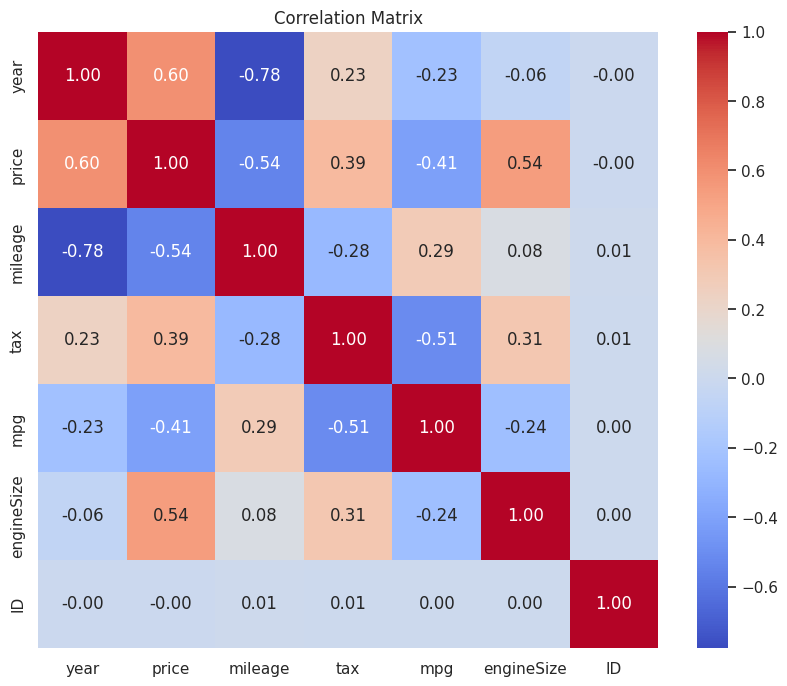

In [15]:
# Correlation matrix
corr_matrix = train.select_dtypes(include=np.number).corr() # Select only numerical columns for correlation calculation

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Column 'Brand' not found in the DataFrame.
Column 'Model' not found in the DataFrame.


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

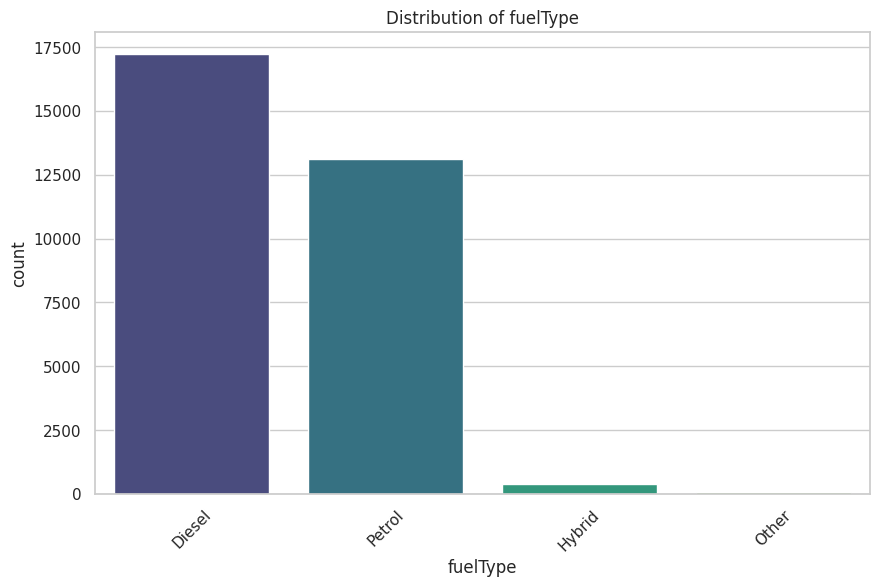

Column 'Transmission' not found in the DataFrame.


<Figure size 1000x600 with 0 Axes>

In [16]:
# List of categorical columns
categorical_cols = ['Brand', 'Model', 'fuelType', 'Transmission']

for col in categorical_cols:
    plt.figure(figsize=(10,6))
    # Check if the column exists in the DataFrame before plotting
    if col in train.columns:
        sns.countplot(data=train, x=col, palette='viridis')
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"Column '{col}' not found in the DataFrame.")

In [17]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(train.isnull().sum())


Missing Values in Each Column:
model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
brand           0
ID              0
dtype: int64


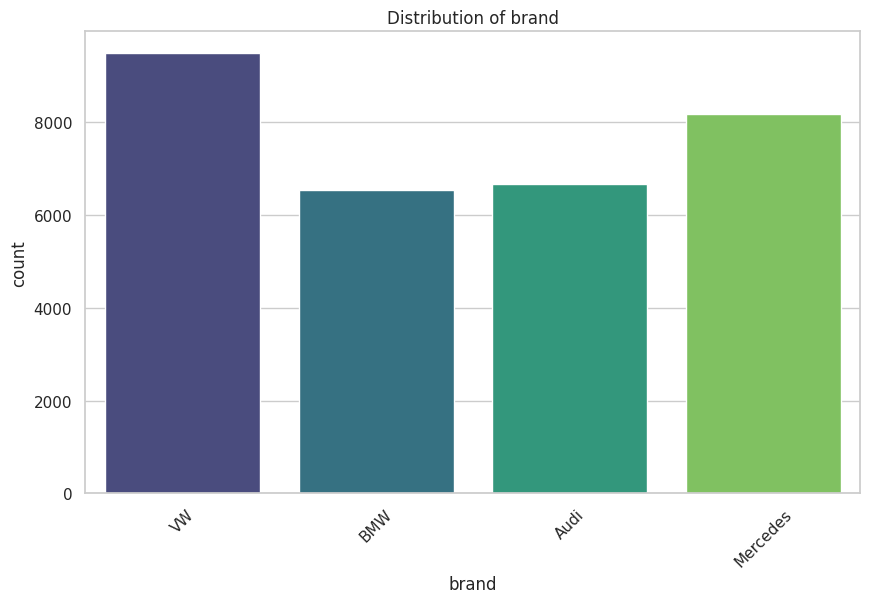

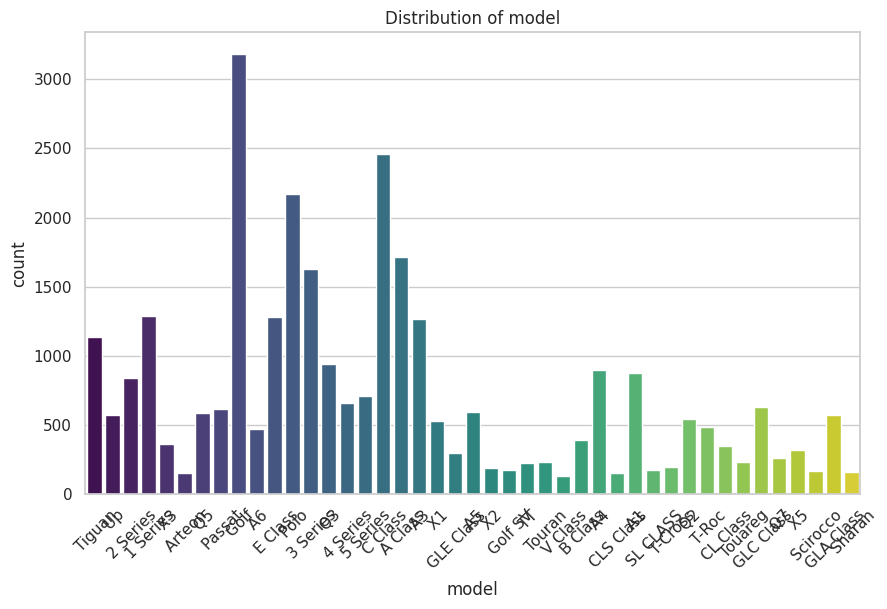

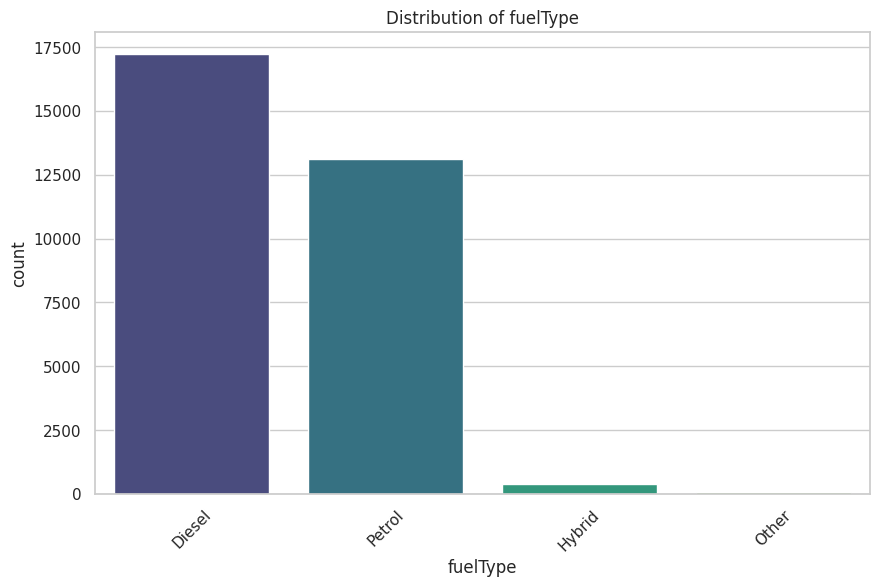

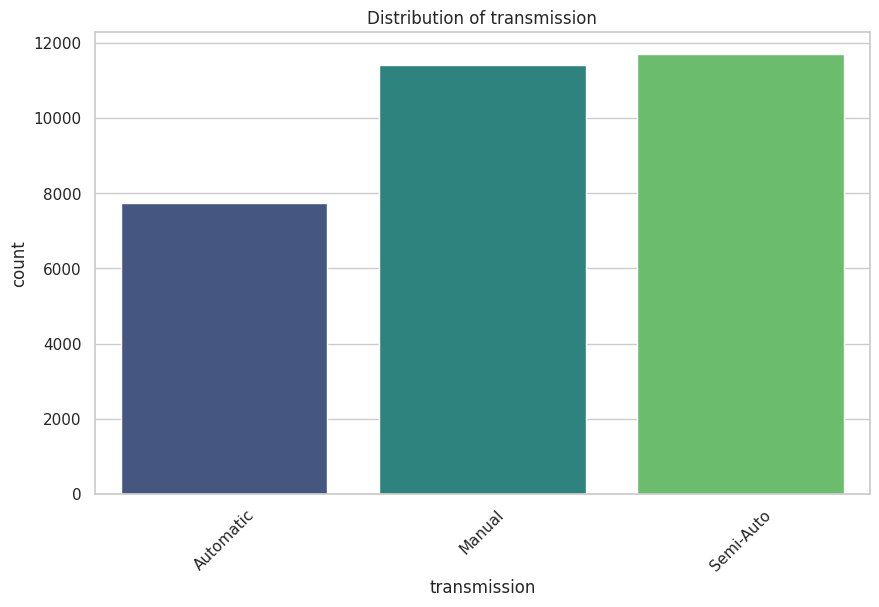


Data after One-Hot Encoding:
   year  price  mileage  tax   mpg  engineSize     ID  brand_BMW  \
0  2020  29999     2728  145  47.9         2.0  40452      False   
1  2018   8750    12500  145  64.2         1.0  33997      False   
2  2019  22646      123  145  52.3         1.5  24566       True   
3  2019  21950     5013  145  44.1         1.5  30438       True   
4  2013  13100    64455  160  50.4         2.0  22552       True   

   brand_Mercedes  brand_VW  ...  model_ V Class  model_ X1  model_ X2  \
0           False      True  ...           False      False      False   
1           False      True  ...           False      False      False   
2           False     False  ...           False      False      False   
3           False     False  ...           False      False      False   
4           False     False  ...           False      False      False   

   model_ X3  model_ X5  fuelType_Hybrid  fuelType_Other  fuelType_Petrol  \
0      False      False            Fals

In [18]:
# List of categorical columns
categorical_cols = ['brand', 'model', 'fuelType', 'transmission'] # Changed column names to lowercase

for col in categorical_cols:
    plt.figure(figsize=(10,6))
    # Check if the column exists in the DataFrame before plotting
    if col in train.columns:
        sns.countplot(data=train, x=col, palette='viridis')
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"Column '{col}' not found in the DataFrame.")

# One-Hot Encoding for categorical variables
data_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)

print("\nData after One-Hot Encoding:")
print(data_encoded.head())

In [19]:
# Create 'Age' feature
current_year = 2023
# Use 'year' instead of 'Year' (assuming case sensitivity was the issue)
data_encoded['Age'] = current_year - data_encoded['year']

# Drop the original 'year' column as 'Age' now captures the necessary information
data_encoded.drop('year', axis=1, inplace=True)

print("\nData after Feature Engineering (Age):")
print(data_encoded.head())


Data after Feature Engineering (Age):
   price  mileage  tax   mpg  engineSize     ID  brand_BMW  brand_Mercedes  \
0  29999     2728  145  47.9         2.0  40452      False           False   
1   8750    12500  145  64.2         1.0  33997      False           False   
2  22646      123  145  52.3         1.5  24566       True           False   
3  21950     5013  145  44.1         1.5  30438       True           False   
4  13100    64455  160  50.4         2.0  22552       True           False   

   brand_VW  model_ 2 Series  ...  model_ X1  model_ X2  model_ X3  model_ X5  \
0      True            False  ...      False      False      False      False   
1      True            False  ...      False      False      False      False   
2     False             True  ...      False      False      False      False   
3     False            False  ...      False      False      False      False   
4     False            False  ...      False      False       True      False   

   fu

In [20]:
# Example: Interaction between Mileage and Age
# Check if 'mileage' exists in the DataFrame; if not, find the modified column name
if 'mileage' in data_encoded.columns:
    data_encoded['Mileage_Age'] = data_encoded['mileage'] * data_encoded['Age']
else:
    for col in data_encoded.columns:
        if 'mileage' in col:
            data_encoded['Mileage_Age'] = data_encoded[col] * data_encoded['Age']
            break  # Exit the loop once the column is found

print("\nData after Creating Interaction Feature (Mileage_Age):")
print(data_encoded.head())


Data after Creating Interaction Feature (Mileage_Age):
   price  mileage  tax   mpg  engineSize     ID  brand_BMW  brand_Mercedes  \
0  29999     2728  145  47.9         2.0  40452      False           False   
1   8750    12500  145  64.2         1.0  33997      False           False   
2  22646      123  145  52.3         1.5  24566       True           False   
3  21950     5013  145  44.1         1.5  30438       True           False   
4  13100    64455  160  50.4         2.0  22552       True           False   

   brand_VW  model_ 2 Series  ...  model_ X2  model_ X3  model_ X5  \
0      True            False  ...      False      False      False   
1      True            False  ...      False      False      False   
2     False             True  ...      False      False      False   
3     False            False  ...      False      False      False   
4     False            False  ...      False       True      False   

   fuelType_Hybrid  fuelType_Other  fuelType_Petrol  t

In [21]:
# Define target and features
X = data_encoded.drop(['ID', 'price'], axis=1) # Changed 'Price' to 'price'
y = data_encoded['price'] # Changed 'Price' to 'price'

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")


Feature Matrix Shape: (30857, 56)
Target Vector Shape: (30857,)


In [22]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining Set Shape: {X_train.shape}")
print(f"Validation Set Shape: {X_val.shape}")


Training Set Shape: (24685, 56)
Validation Set Shape: (6172, 56)


# 1. LINEAR REGRESSION

In [23]:
# Import the necessary module
from sklearn.linear_model import LinearRegression

# Initialize and train Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on validation set
y_pred_lr = lr.predict(X_val)

# Evaluate the model
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
mae_lr = mean_absolute_error(y_val, y_pred_lr)
r2_lr = r2_score(y_val, y_pred_lr)

print("\nLinear Regression Performance on Validation Set:")
print(f"RMSE: {rmse_lr:.2f}")
print(f"MAE: {mae_lr:.2f}")
print(f"R² Score: {r2_lr:.4f}")


Linear Regression Performance on Validation Set:
RMSE: 4043.71
MAE: 2545.20
R² Score: 0.8338


# 2. RANDOM FOREST REGRESSOR

In [24]:
# Import the necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# Initialize and train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on validation set
y_pred_rf = rf.predict(X_val)

# Evaluate the model
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
mae_rf = mean_absolute_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

print("\nRandom Forest Regressor Performance on Validation Set:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")


Random Forest Regressor Performance on Validation Set:
RMSE: 2507.46
MAE: 1418.70
R² Score: 0.9361


# 3. XGBOOST REGRESSOR

In [25]:
# Initialize and train XGBoost model
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=0
)
xgb_reg.fit(X_train, y_train)

# Predict on validation set
y_pred_xgb = xgb_reg.predict(X_val)

# Evaluate the model
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
r2_xgb = r2_score(y_val, y_pred_xgb)

print("\nXGBoost Regressor Performance on Validation Set:")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")


XGBoost Regressor Performance on Validation Set:
RMSE: 2597.52
MAE: 1607.40
R² Score: 0.9314


# Optimizing XGBoost with Optuna

In [26]:
def objective_xgb(trial):
    """
    Objective function for Optuna to optimize XGBoost hyperparameters.
    """
    param = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',  # Efficient for large datasets
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2.0),
        'random_state': 42,
        'verbosity': 0
    }

    # Initialize XGBoost regressor with current hyperparameters
    model = xgb.XGBRegressor(**param)

    # Set up cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation
    scores = cross_val_score(
        model, X_train, y_train,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1
    )

    # Return the average RMSE
    return -scores.mean()

# Create the Optuna study for XGBoost
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=50, timeout=1200)  # 50 trials or 20 minutes

print("\nXGBoost Best Hyperparameters:")
print(study_xgb.best_params)
print(f"XGBoost Best RMSE: {study_xgb.best_value:.2f}")

[I 2024-09-27 21:52:01,698] A new study created in memory with name: no-name-e2b2f3f8-0e5a-4e8d-89eb-41aeb6036667
[I 2024-09-27 21:52:09,447] Trial 0 finished with value: 2137.717992331005 and parameters: {'learning_rate': 0.1225929033116577, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9825668310915783, 'colsample_bytree': 0.6369271492870501, 'reg_alpha': 0.6808673700247071, 'reg_lambda': 0.5472317300458571}. Best is trial 0 with value: 2137.717992331005.
[I 2024-09-27 21:52:12,439] Trial 1 finished with value: 2386.9586987507582 and parameters: {'learning_rate': 0.05313201000411026, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.5727599740164511, 'colsample_bytree': 0.9365526269029703, 'reg_alpha': 0.20672410184950585, 'reg_lambda': 1.0723265840668383}. Best is trial 0 with value: 2137.717992331005.
[I 2024-09-27 21:52:14,662] Trial 2 finished with value: 2272.178329305326 and parameters: {'learning_rate': 0.25404341970489586, 'max_depth': 7, 'min_child_weight': 9, 's


XGBoost Best Hyperparameters:
{'learning_rate': 0.12594555459375545, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9424905834138662, 'colsample_bytree': 0.9416960503683965, 'reg_alpha': 0.32656446634624486, 'reg_lambda': 1.5701366448641414}
XGBoost Best RMSE: 2130.17


# Optimising LightGBM with Optuna

In [27]:
def objective_lgb(trial):
    """
    Objective function for Optuna to optimize LightGBM hyperparameters.
    """
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    # Initialize LightGBM regressor with current hyperparameters
    model = lgb.LGBMRegressor(**param)

    # Set up cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation
    scores = cross_val_score(
        model, X_train, y_train,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1
    )

    # Return the average RMSE
    return -scores.mean()

# Create the Optuna study for LightGBM
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=50, timeout=1200)  # 50 trials or 20 minutes

print("\nLightGBM Best Hyperparameters:")
print(study_lgb.best_params)
print(f"LightGBM Best RMSE: {study_lgb.best_value:.2f}")

[I 2024-09-27 21:55:14,522] A new study created in memory with name: no-name-e24f14be-8198-4a64-ae7b-6fcb1361794b
[I 2024-09-27 21:55:17,906] Trial 0 finished with value: 4444.381863302644 and parameters: {'learning_rate': 0.014096857768182725, 'num_leaves': 29, 'max_depth': 8, 'min_child_samples': 99, 'subsample': 0.9894269554215629, 'colsample_bytree': 0.5831757498708998, 'reg_alpha': 0.3163699926032202, 'reg_lambda': 0.02099873271043029}. Best is trial 0 with value: 4444.381863302644.
[I 2024-09-27 21:55:19,524] Trial 1 finished with value: 2907.9697796350615 and parameters: {'learning_rate': 0.08520670897636634, 'num_leaves': 67, 'max_depth': 5, 'min_child_samples': 97, 'subsample': 0.5819140064710953, 'colsample_bytree': 0.9224102745838131, 'reg_alpha': 0.21201421041801383, 'reg_lambda': 0.42779317930253047}. Best is trial 1 with value: 2907.9697796350615.
[I 2024-09-27 21:55:23,654] Trial 2 finished with value: 4128.655008750826 and parameters: {'learning_rate': 0.012672151648084


LightGBM Best Hyperparameters:
{'learning_rate': 0.17306361634112502, 'num_leaves': 121, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.5768621628181045, 'colsample_bytree': 0.7247989796395847, 'reg_alpha': 0.712378787410916, 'reg_lambda': 0.46539563386175364}
LightGBM Best RMSE: 2114.96


# Optimizing CatBoost with Optuna

In [28]:
def objective_cat(trial):
    """
    Objective function for Optuna to optimize CatBoost hyperparameters.
    """
    param = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'thread_count': -1,
        'verbose': False,
        'random_seed': 42
    }

    # Initialize CatBoost regressor with current hyperparameters
    model = CatBoostRegressor(**param)

    # Set up cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation
    scores = cross_val_score(
        model, X_train, y_train,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1
    )

    # Return the average RMSE
    return -scores.mean()

# Create the Optuna study for CatBoost
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=50, timeout=1200)  # 50 trials or 20 minutes

print("\nCatBoost Best Hyperparameters:")
print(study_cat.best_params)
print(f"CatBoost Best RMSE: {study_cat.best_value:.2f}")

[I 2024-09-27 21:56:51,213] A new study created in memory with name: no-name-153a5b6e-1f25-4e77-bdf5-2911c0887475
[I 2024-09-27 21:57:47,254] Trial 0 finished with value: 2124.699481850873 and parameters: {'learning_rate': 0.18816808922479755, 'depth': 9, 'l2_leaf_reg': 2.4107722090447496, 'bagging_temperature': 0.3881787740091601, 'random_strength': 0.06322540933801257, 'border_count': 61}. Best is trial 0 with value: 2124.699481850873.
[I 2024-09-27 21:58:57,850] Trial 1 finished with value: 2092.6397214934714 and parameters: {'learning_rate': 0.08656679801327859, 'depth': 9, 'l2_leaf_reg': 2.2959570776944656, 'bagging_temperature': 0.30175712101154706, 'random_strength': 0.9832391190188714, 'border_count': 240}. Best is trial 1 with value: 2092.6397214934714.
[I 2024-09-27 21:59:57,596] Trial 2 finished with value: 2080.6085762513912 and parameters: {'learning_rate': 0.28494156801418563, 'depth': 9, 'l2_leaf_reg': 7.726389018658828, 'bagging_temperature': 0.7711399961051981, 'random


CatBoost Best Hyperparameters:
{'learning_rate': 0.11571701848262733, 'depth': 9, 'l2_leaf_reg': 2.1355015444734957, 'bagging_temperature': 0.31787462854279, 'random_strength': 0.8647035348511487, 'border_count': 191}
CatBoost Best RMSE: 2072.94


# Visualization of Hyperparameter Optimization

In [29]:
# Install plotly for interactive plots if not already installed
# !pip install plotly

import optuna.visualization as vis

# Plot the optimization history for XGBoost
fig_xgb = vis.plot_optimization_history(study_xgb)
fig_xgb.show()

# Plot the hyperparameter importance for XGBoost
fig_xgb_importance = vis.plot_param_importances(study_xgb)
fig_xgb_importance.show()

# Similarly, plot for LightGBM
fig_lgb = vis.plot_optimization_history(study_lgb)
fig_lgb.show()

fig_lgb_importance = vis.plot_param_importances(study_lgb)
fig_lgb_importance.show()

# Similarly, plot for CatBoost
fig_cat = vis.plot_optimization_history(study_cat)
fig_cat.show()

fig_cat_importance = vis.plot_param_importances(study_cat)
fig_cat_importance.show()

# Final Model Training and Evaluation

In [30]:
# Retrieve the best hyperparameters for each model
best_params_xgb = study_xgb.best_params
best_params_xgb.update({
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'random_state': 42,
    'verbosity': 0
})

best_params_lgb = study_lgb.best_params
best_params_lgb.update({
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': 42
})

best_params_cat = study_cat.best_params
best_params_cat.update({
    'iterations': 1000,
    'thread_count': -1,
    'verbose': False,
    'random_seed': 42
})

print("\nFinal XGBoost Hyperparameters:")
print(best_params_xgb)

print("\nFinal LightGBM Hyperparameters:")
print(best_params_lgb)

print("\nFinal CatBoost Hyperparameters:")
print(best_params_cat)


Final XGBoost Hyperparameters:
{'learning_rate': 0.12594555459375545, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9424905834138662, 'colsample_bytree': 0.9416960503683965, 'reg_alpha': 0.32656446634624486, 'reg_lambda': 1.5701366448641414, 'objective': 'reg:squarederror', 'tree_method': 'hist', 'eval_metric': 'rmse', 'random_state': 42, 'verbosity': 0}

Final LightGBM Hyperparameters:
{'learning_rate': 0.17306361634112502, 'num_leaves': 121, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.5768621628181045, 'colsample_bytree': 0.7247989796395847, 'reg_alpha': 0.712378787410916, 'reg_lambda': 0.46539563386175364, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'verbosity': -1, 'random_state': 42}

Final CatBoost Hyperparameters:
{'learning_rate': 0.11571701848262733, 'depth': 9, 'l2_leaf_reg': 2.1355015444734957, 'bagging_temperature': 0.31787462854279, 'random_strength': 0.8647035348511487, 'border_count': 191, 'iterations': 1000, 'thread_count'

# Training the Final Models

In [31]:
# Initialize the models with best hyperparameters
final_xgb = xgb.XGBRegressor(**best_params_xgb)
final_lgb = lgb.LGBMRegressor(**best_params_lgb)
final_cat = CatBoostRegressor(**best_params_cat)

# Train the models
print("\nTraining Final XGBoost Model...")
final_xgb.fit(X_train, y_train)

print("Training Final LightGBM Model...")
final_lgb.fit(X_train, y_train)

print("Training Final CatBoost Model...")
final_cat.fit(X_train, y_train)


Training Final XGBoost Model...
Training Final LightGBM Model...
Training Final CatBoost Model...


# Creating the Stacking Ensemble

In [32]:
# Define the base learners
base_learners = [
    ('xgb', final_xgb),
    ('lgbm', final_lgb),
    ('cat', final_cat)
]

# Define the meta-learner
meta_learner = LinearRegression()

# Initialize the Stacking Regressor
stacking_reg = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Train the Stacking Ensemble
print("\nTraining Stacking Ensemble Model...")
stacking_reg.fit(X_train, y_train)


Training Stacking Ensemble Model...


StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9416960503683965,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='rmse',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constra...
                               LGBMRegressor(colsample_bytree=0.7247989796395847,
                                             learning_rate=0.17306361634112502,
                                             max_depth=10, metric='rmse',
                                             min_child_samples=5,
                                             num_leaves=121,
                                             objective='regression',
                                             random_state=42,
                                             reg_alpha=0.712378787410916,
                                             reg_lambda=0.46539563386175364,
                                             subsample=0.5768621628181045,
                                             verbosity=-1)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x7e81a7773310>)],
                  final_estimator=LinearRegression(), n_jobs=-1)

# Evaluating the Stacking Ensemble


Stacking Ensemble Model Performance on Validation Set:
RMSE: 2397.49
MAE: 1306.42
R² Score: 0.9416


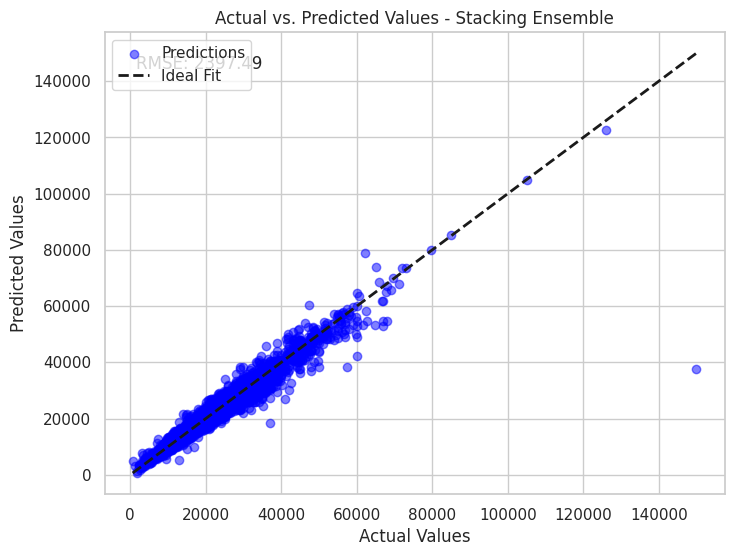

In [33]:
# Import matplotlib for plotting (if not already imported)
import matplotlib.pyplot as plt

# Predict on validation set
y_pred_stack = stacking_reg.predict(X_val)

# Evaluate the ensemble model
rmse_stack = np.sqrt(mean_squared_error(y_val, y_pred_stack))
mae_stack = mean_absolute_error(y_val, y_pred_stack)
r2_stack = r2_score(y_val, y_pred_stack)

print("\nStacking Ensemble Model Performance on Validation Set:")
print(f"RMSE: {rmse_stack:.2f}")
print(f"MAE: {mae_stack:.2f}")
print(f"R² Score: {r2_stack:.4f}")


# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_stack, alpha=0.5, color='blue', label='Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values - Stacking Ensemble')

# Annotate the plot with RMSE
plt.text(0.05, 0.95, f'RMSE: {rmse_stack:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True)
plt.show()

# Making Predictions on Test Data

In [36]:
# ==========================================
# Step 13: Making Predictions on Test Data
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# Assumptions:
# - 'train' and 'test' DataFrames are already loaded.
# - 'X' is the training feature set (excluding target variable).
# - 'stacking_reg' is your trained Stacking Regressor model.
# - 'current_year' is defined (e.g., 2024).
# ==========================================

# 1. Standardize Column Names to Lowercase
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

print("Training DataFrame Columns After Lowercasing:")
print(train.columns.tolist())

print("\nTest DataFrame Columns After Lowercasing:")
print(test.columns.tolist())

# 2. Define Categorical Columns (All Lowercase)
categorical_cols = ['brand', 'model', 'fueltype', 'transmission']

# 3. Handle Missing Categorical Columns in Test Data
for col in categorical_cols:
    if col not in test.columns:
        print(f"Warning: '{col}' column not found in test data. Adding it with default value 'Unknown'.")
        test[col] = 'Unknown'  # Assign a default category or appropriate value

# 4. Clean Categorical Features (Strip Leading/Trailing Spaces)
for col in categorical_cols:
    if col in test.columns:
        test[col] = test[col].str.strip()
    else:
        print(f"Warning: '{col}' column not found in test data.")

# 5. One-Hot Encode Categorical Variables in Test Data
test_encoded = pd.get_dummies(test, columns=categorical_cols, drop_first=True)

print("\nTest Encoded DataFrame Columns After One-Hot Encoding:")
print(test_encoded.columns.tolist())

# 6. Align Test Data Features with Training Data Features
# Identify missing columns in test_encoded that are present in training data (X)
missing_cols = set(X.columns) - set(test_encoded.columns)

# Exclude non-feature columns if present (e.g., 'id')
non_feature_cols = {'id'}
missing_cols = missing_cols - non_feature_cols

# Add missing columns to test_encoded with default value 0
for col in missing_cols:
    test_encoded[col] = 0
    print(f"Added missing column '{col}' with default value 0.")

# Identify extra columns in test_encoded that are not present in training data
extra_cols = set(test_encoded.columns) - set(X.columns)

# Exclude identifier columns (e.g., 'id') from being dropped
identifier_cols = {'id'}
extra_cols = extra_cols - identifier_cols

if extra_cols:
    test_encoded.drop(columns=extra_cols, inplace=True)
    print(f"\nDropped extra columns not present in training data: {extra_cols}")

# Reorder test_encoded columns to match the training data's feature order
test_encoded = test_encoded[X.columns]

print("\nTest Encoded DataFrame Columns After Alignment:")
print(test_encoded.columns.tolist())

#Import the necessary module
from sklearn.preprocessing import StandardScaler # You can also use MinMaxScaler

# 7. Define Numerical Features to Scale (All Lowercase)
features_to_scale = ['mileage', 'tax', 'mpg'] # Removed 'year' and 'enginesize'

# Check for any missing scaling columns and handle them
missing_scaling_cols = set(features_to_scale) - set(test_encoded.columns)
if missing_scaling_cols:
    print(f"\nMissing columns for scaling: {missing_scaling_cols}")
    for col in missing_scaling_cols:
        test_encoded[col] = 0
        print(f"Added missing scaling column '{col}' with default value 0.")

#Fit the scaler on training data
scaler = StandardScaler() #Instantiate a scaler object
scaler.fit(X[features_to_scale]) #Fit the scaler on the training data


# 8. Scale the Numerical Features
try:
    test_encoded[features_to_scale] = scaler.transform(test_encoded[features_to_scale])
    print("\nNumerical features scaled successfully.")
except ValueError as e:
    print(f"\nError during scaling: {e}")
    print("Ensure that the test data's numerical features match the training data's features.")
    # Optionally, handle the error, e.g., abort or attempt to fix

# 9. Add 'Age' Feature
if 'year' in test_encoded.columns:
    test_encoded['age'] = current_year - test_encoded['year']
    test_encoded.drop('year', axis=1, inplace=True)
    print("Added 'age' feature and dropped 'year' column.")
else:
    print("Error: 'year' column is missing after alignment. Cannot compute 'age'. Setting 'age' to 0.")
    test_encoded['age'] = 0

# 10. Add Interaction Feature 'Mileage_Age' if it Exists in Training Data
# Assuming 'mileage_age' was an engineered feature in training data
if 'mileage_age' in X.columns:
    test_encoded['mileage_age'] = test_encoded['mileage'] * test_encoded['age']
    print("Added 'mileage_age' interaction feature.")
else:
    print("'mileage_age' feature does not exist in training data. Skipping interaction feature.")

# 11. Final Verification of Test Data Preprocessing
print("\nColumns in Test Encoded Data After Preprocessing:")
print(test_encoded.columns.tolist())

print("\nTest Data Prepared for Prediction:")
print(test_encoded.head())

Training DataFrame Columns After Lowercasing:
['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax', 'mpg', 'enginesize', 'brand', 'id']

Test DataFrame Columns After Lowercasing:
['model', 'year', 'transmission', 'mileage', 'fueltype', 'tax', 'mpg', 'enginesize', 'brand', 'id']

Test Encoded DataFrame Columns After One-Hot Encoding:
['year', 'mileage', 'tax', 'mpg', 'enginesize', 'id', 'brand_BMW', 'brand_Mercedes', 'brand_VW', 'model_2 Series', 'model_3 Series', 'model_4 Series', 'model_5 Series', 'model_A Class', 'model_A1', 'model_A3', 'model_A4', 'model_A5', 'model_A6', 'model_Arteon', 'model_B Class', 'model_C Class', 'model_CL Class', 'model_CLS Class', 'model_E Class', 'model_GLA Class', 'model_GLC Class', 'model_GLE Class', 'model_Golf', 'model_Golf SV', 'model_Passat', 'model_Polo', 'model_Q2', 'model_Q3', 'model_Q5', 'model_Q7', 'model_SL CLASS', 'model_Scirocco', 'model_Sharan', 'model_T-Cross', 'model_T-Roc', 'model_TT', 'model_Tiguan', 'model_Touareg', '

In [39]:
# Evaluate the ensemble model
rmse_stack = np.sqrt(mean_squared_error(y_val, y_pred_stack))
mae_stack = mean_absolute_error(y_val, y_pred_stack)
r2_stack = r2_score(y_val, y_pred_stack)

print("\nStacking Ensemble Model Performance on Validation Set:")
print(f"RMSE: {rmse_stack:.2f}")
print(f"MAE: {mae_stack:.2f}")
print(f"R² Score: {r2_stack:.4f}")


Stacking Ensemble Model Performance on Validation Set:
RMSE: 2397.49
MAE: 1306.42
R² Score: 0.9416


In [37]:
# ==========================================
# Step 14: Making Predictions
# ==========================================

# Predict on the test set using the Stacking Ensemble
try:
    # Ensure test_encoded has the same columns as the data the model was trained on
    test_encoded = test_encoded[X.columns]
    test_predictions = stacking_reg.predict(test_encoded) # Make predictions and store the results in the variable
    print("\nPredictions made successfully.")
except ValueError as e:
    print(f"\nError during prediction: {e}")
    print("Ensure that the test data has the exact same features as the training data.")
    test_predictions = [] # Assign an empty list to test_predictions in case of an error to avoid NameError
    # Optionally, handle the error, e.g., by aborting or attempting to fix

# Add predictions to the test DataFrame
test['predicted_price'] = test_predictions

print("\nSample Predictions:")
print(test[['id', 'predicted_price']].head())


Predictions made successfully.

Sample Predictions:
   id  predicted_price
0   1     27050.992007
1   4     34228.110645
2  10     32167.166213
3  13     33488.181142
4  16     29491.189590


# Saving Predictions

In [38]:
import pandas as pd
import numpy as np

# Define the file name
file_name = "Group6_SaraTestSubmission.csv"

def save_submission_for_kaggle(file_name, test_predictions, test):
    """
    Saves the predictions to a CSV file in the required submission format.

    Parameters:
    - file_name: str, name of the file to save.
    - test_predictions: array-like, predicted prices.
    - test: DataFrame, original test data containing 'id'.
    """
    # Check if 'id' exists in test DataFrame (all lowercase)
    if 'id' in test.columns:
        # Create submission DataFrame with 'ID' and 'Actual' instead of 'Price'
        submission_data = pd.DataFrame({
            "ID": test["id"].astype(int),
            "Actual": test_predictions  # Renamed column 'Price' to 'Actual'
        })
    else:
        # If 'id' does not exist, create a sequential ID starting from 1
        print("Warning: 'id' column not found in test data. Creating sequential IDs.")
        submission_data = pd.DataFrame({
            "ID": np.arange(1, len(test_predictions) + 1),
            "Actual": test_predictions  # Renamed column 'Price' to 'Actual'
        })

    # Ensure that only the required columns are present
    required_columns = ['ID', 'Actual']
    submission_data = submission_data[required_columns]

    # Save the submission DataFrame to a CSV file without the index
    submission_data.to_csv(file_name, index=False)
    print(f"\nPredictions saved to '{file_name}' with columns: {submission_data.columns.tolist()}")

# Save the submission
save_submission_for_kaggle(file_name, test_predictions, test)

# ==========================================
# Step 16: Download the Submission File (Google Colab Only)
# ==========================================

# Attempt to download the file if using Google Colab
try:
    from google.colab import files
    files.download(file_name)
except ModuleNotFoundError:
    print("Not using Google Colab")


Predictions saved to 'Group6_SaraTestSubmission.csv' with columns: ['ID', 'Actual']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Interactive Car Price Prediction

In [41]:
# ==========================================
# Step 14: Quick Demo to Predict Car Price
# ==========================================

# Sample input data for prediction
# You can replace these values with any valid car feature values
# The values here should correspond to the same columns as in X_train

# Example: VW Golf, 2019, Manual, 25000 mileage, Petrol, 145 tax, 47.9 mpg, engineSize = 1.5, Age = 4
demo_data = {
    'mileage': [25000],
    'tax': [145],
    'mpg': [47.9],
    'engineSize': [1.5],
    # 'Age': [2023 - 2019], # Calculate 'Age' after creating the DataFrame to avoid potential issues
    'brand_VW': [1],  # VW is 1 (binary encoded), rest of the brands should be 0
    'brand_BMW': [0],
    'brand_Mercedes': [0],
    'fuelType_Petrol': [1],  # Petrol is 1 (binary encoded), rest should be 0
    'fuelType_Diesel': [0],
    'fuelType_Hybrid': [0],
    'fuelType_Other': [0],
    'transmission_Manual': [1],  # Manual transmission, rest should be 0
    'transmission_Automatic': [0],
    'transmission_Semi-Auto': [0],
    # Add other model columns based on one-hot encoding, setting correct values
    # ... (Add all other model columns from X_train with 0 values)
}

# Convert demo data into a DataFrame
demo_df = pd.DataFrame(demo_data)

# Calculate 'Age' column
demo_df['Age'] = 2023 - 2019

# Ensure demo_df has the same columns as X_train
for col in X_train.columns:
    if col not in demo_df.columns:
        demo_df[col] = 0

# Make sure to scale the numerical features in the demo data (similar to training data)
features_to_scale = ['mileage', 'tax', 'mpg', 'engineSize', 'Age']
scaler = StandardScaler()
demo_df[features_to_scale] = scaler.fit_transform(demo_df[features_to_scale])

# Reorder columns to match X_train
demo_df = demo_df[X_train.columns]

# Predict the price using the stacking model
predicted_price = stacking_reg.predict(demo_df)

# Output the result
print(f"Predicted Car Price: ${predicted_price[0]:,.2f}")

Predicted Car Price: $27,327.50
